In [2]:
from spherinator.data import ParquetDataModule

datamodule = ParquetDataModule(
    "/home/doserbd/data/gaia/xp_sampled_mean_spectrum/parquet",
    data_column="flux",
    batch_size=10,
    num_workers=1,
    shuffle=False,
)
datamodule.setup("fit")

batch = next(iter(datamodule.train_dataloader()))
batch.shape

torch.Size([10, 1, 344])

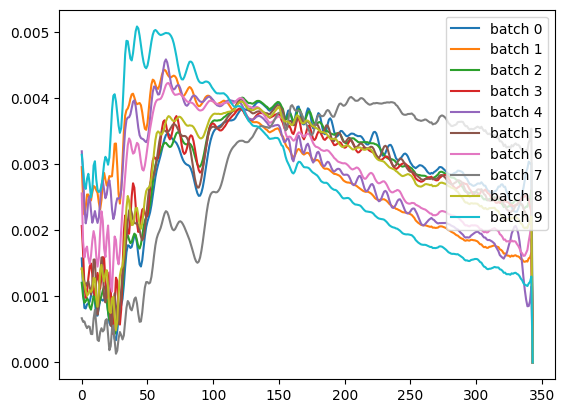

In [3]:
from matplotlib import pyplot as plt
plt.figure()
for i in range(10):
    plt.plot(batch[i][0].cpu().detach().numpy(), label=f"batch {i}")
plt.legend(loc="upper right")
plt.show()

In [4]:
import yaml
from lightning.pytorch.cli import instantiate_class
import importlib

with open("/home/doserbd/git/Spherinator-main/experiments/gaia.yaml", "r", encoding="utf-8") as stream:
    config = yaml.load(stream, Loader=yaml.Loader)

model_class_path = config["model"]["class_path"]
module_name, class_name = model_class_path.rsplit(".", 1)
module_name, class_name

('spherinator.models', 'VariationalAutoencoder')

In [5]:
module = importlib.import_module(module_name)
model_class = getattr(module, class_name)
model_init_args = config["model"]["init_args"]
model_init_args

{'encoder': {'class_path': 'spherinator.models.ConvolutionalEncoder1D',
  'init_args': {'input_dim': 344, 'output_dim': 256}},
 'decoder': {'class_path': 'spherinator.models.ConvolutionalDecoder1D',
  'init_args': {'input_dim': 256, 'output_dim': 344}},
 'h_dim': 256,
 'z_dim': 3,
 'beta': 0.001}

In [6]:
model = model_class(**model_init_args)
model

VariationalAutoencoder(
  (fc_location): Linear(in_features=256, out_features=3, bias=True)
  (fc_scale): Linear(in_features=256, out_features=1, bias=True)
  (fc2): Linear(in_features=3, out_features=256, bias=True)
)

In [7]:
from spherinator.models import (
    ConvolutionalDecoder1D,
    ConvolutionalEncoder1D,
    VariationalAutoencoder,
)

encoder = ConvolutionalEncoder1D(input_dim=344, output_dim=256)
decoder = ConvolutionalDecoder1D(input_dim=256, output_dim=344)
model = VariationalAutoencoder(encoder=encoder, decoder=decoder, h_dim=256, z_dim=3)
model

/home/doserbd/git/Spherinator-main/.venv/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/home/doserbd/git/Spherinator-main/.venv/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.


VariationalAutoencoder(
  (encoder): ConvolutionalEncoder1D(
    (enc1): Sequential(
      (0): Conv1d(1, 32, kernel_size=(4,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (enc2): Sequential(
      (0): Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (enc3): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=5504, out_features=256, bias=True)
    )
  )
  (decoder): ConvolutionalDecoder1D(
    (dec1): Sequential(
      (0): Linear(in_features=256, out_features=5504, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(64, 86))
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (dec2): Sequential(
      (0): ConvTranspose1d(64, 32, kernel_size=(4,), stri

In [8]:
import torch

ckpt = "/home/doserbd/git/Spherinator-main/gaia/ju27a0o6/checkpoints/epoch=99-step=180500.ckpt"
checkpoint = torch.load(ckpt, weights_only=True, map_location="cpu")
checkpoint

{'epoch': 99,
 'global_step': 180500,
 'pytorch-lightning_version': '2.4.0',
 'state_dict': OrderedDict([('encoder.enc1.0.weight',
               tensor([[[-0.4660, -0.1776,  0.1720,  0.4938]],
               
                       [[ 0.0915,  0.4878,  0.0933,  0.2813]],
               
                       [[ 0.3649,  0.3801, -0.3178,  0.4210]],
               
                       [[ 0.3243, -0.2118, -0.2226, -0.4027]],
               
                       [[ 0.1076, -0.4201,  0.2026,  0.1528]],
               
                       [[-0.4430,  0.1322, -0.0506,  0.2196]],
               
                       [[ 0.2831, -0.5115,  0.4400,  0.3954]],
               
                       [[ 0.1957, -0.4607, -0.1850, -0.1530]],
               
                       [[-0.1411,  0.2552,  0.1514,  0.3642]],
               
                       [[-0.2119,  0.1480,  0.1491, -0.4450]],
               
                       [[-0.4942, -0.2726,  0.3377, -0.4707]],
               


In [9]:
model.load_state_dict(checkpoint["state_dict"])
model.eval()

VariationalAutoencoder(
  (encoder): ConvolutionalEncoder1D(
    (enc1): Sequential(
      (0): Conv1d(1, 32, kernel_size=(4,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (enc2): Sequential(
      (0): Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (enc3): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=5504, out_features=256, bias=True)
    )
  )
  (decoder): ConvolutionalDecoder1D(
    (dec1): Sequential(
      (0): Linear(in_features=256, out_features=5504, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(64, 86))
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (dec2): Sequential(
      (0): ConvTranspose1d(64, 32, kernel_size=(4,), stri

In [10]:
(z_location, z_scale), (_, _), _, recon = model(batch)
z_location

tensor([[ 0.4413, -0.8971,  0.0202],
        [-0.4655,  0.8843, -0.0361],
        [ 0.4113, -0.9115,  0.0065],
        [ 0.3110, -0.9456, -0.0955],
        [-0.4670,  0.8835, -0.0353],
        [ 0.3884, -0.9214, -0.0118],
        [-0.4724,  0.8807, -0.0355],
        [ 0.4570, -0.8880,  0.0516],
        [-0.5362,  0.8417, -0.0629],
        [-0.4652,  0.8844, -0.0371]], grad_fn=<DivBackward0>)

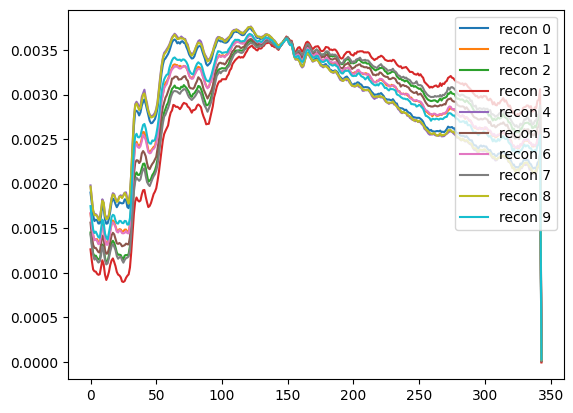

In [16]:
plt.figure()
for i in range(10):
    plt.plot(recon[i][0].cpu().detach().numpy(), label=f"recon {i}")
plt.legend(loc="upper right")
plt.show()

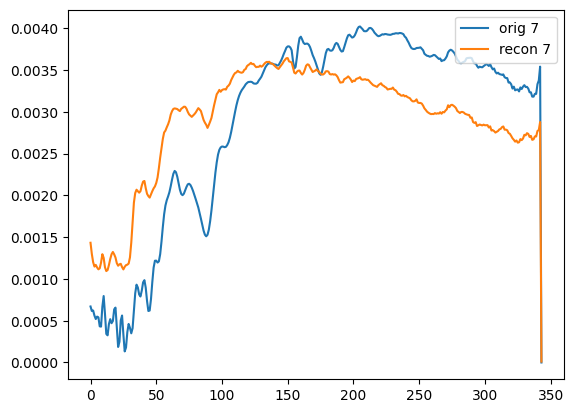

In [19]:
id = 7
plt.figure()
plt.plot(batch[id][0].cpu().detach().numpy(), label=f"orig {id}")
plt.plot(recon[id][0].cpu().detach().numpy(), label=f"recon {id}")
plt.legend(loc="upper right")
plt.show()